# VIX Stock Forecasting using Neural Networks

Downloaded from: https://ca.finance.yahoo.com/quote/FB/history?period1=1337313600&period2=1551502800&interval=1d&filter=history&frequency=1d

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import LSTM

/Users/elder/my-virtualenv/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
df = pd.read_csv('VIX.csv')
df['Date'] = pd.to_datetime(df['Date'])
# df.drop(['Open','High','Low','Adj Close', 'Volume'], axis=1, inplace=True)
df.drop(['Adj Close','Volume'], axis=1, inplace=True)
df = df.set_index(['Date'], drop=True)
df.head()

,Open,High,Low,Close
Date,,,,
2011-02-16,16.309999,16.740000,15.840000,16.719999
2011-02-17,17.010000,17.299999,15.880000,16.590000
2011-02-18,16.590000,16.910000,15.540000,16.430000
2011-02-22,19.459999,21.450001,18.379999,20.799999
2011-02-23,20.840000,23.219999,20.299999,22.129999


## Test and train split

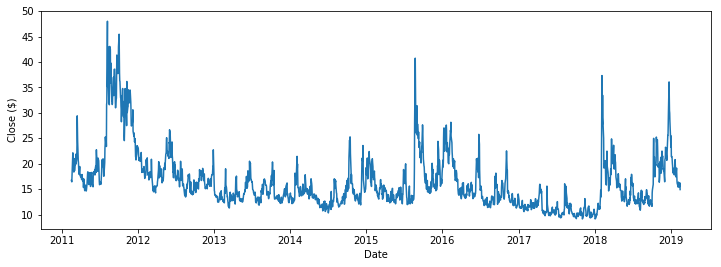

In [3]:
plt.figure(figsize=(12, 4))
plt.plot(df.Close)
plt.ylabel('Close ($)')
plt.xlabel('Date')
plt.show()

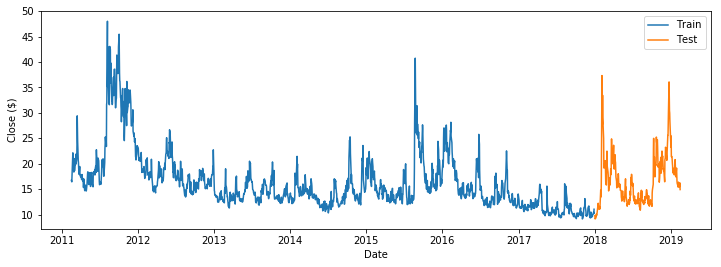

In [4]:
## Training data will be prior to Jan 1st 2018, will test on the rest
split_date = pd.Timestamp('2018-01-01')
train = df.query('Date < "2018-01-01"')
test = df.query('Date >= "2018-01-01"')

plt.figure(figsize=(12, 4))
plt.plot(train.Close, label='Train')
plt.plot(test.Close, label='Test')
plt.ylabel('Close ($)')
plt.xlabel('Date')
plt.legend()
plt.show()

## Scaling

In [23]:
scaler = MinMaxScaler(feature_range=(-1,1))
train_sc = scaler.fit_transform(train)
test_sc = scaler.transform(test)

## Need to scale `Close` separately in order to be able to invert the scale later
scaler_y = MinMaxScaler(feature_range=(-1,1))
y_train_sc = scaler_y.fit_transform(train[:][['Close']])
y_test_sc = scaler_y.transform(test[:][['Close']])

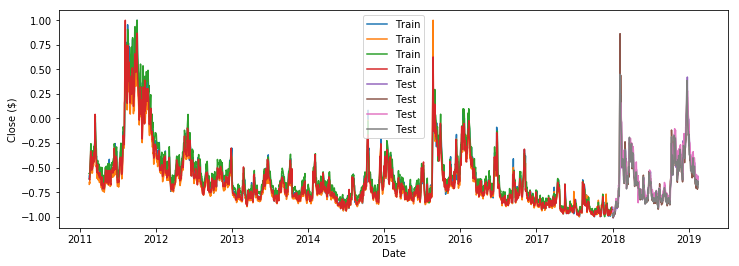

In [24]:
plt.figure(figsize=(12, 4))
plt.plot(train.index, train_sc, label='Train')
plt.plot(test.index, test_sc, label='Test')
plt.ylabel('Close ($)')
plt.xlabel('Date')
plt.legend()
plt.show()

### Will use the previous days's {Open,Low,High,Close} to predict the current day's Close

In [25]:
## Get {Open,Low,High,Close} for all days except the last one
X_train = train_sc[:-1]
X_test = test_sc[:-1]

# Get {Close} for all days except the first one
y_train = y_train_sc[1:]
y_test = y_test_sc[1:]

## Simple Neural Network
Will use the `Sequential` Keras model to build a simple 2-layer linear network. The first layer has 12 neurons with a `ReLu` activation function. It takes the (4-dimensional) info from the previous day as input. The second layer collects it all into a single neuron with the final ouput.

In [8]:
nn_model = Sequential()
# nn_model.add(Dense(12, input_dim=1, activation='relu'))
nn_model.add(Dense(12, input_dim=4, activation='relu'))
# nn_model.add(Dense(12, input_dim=4, activation='relu'))
nn_model.add(Dense(1))
nn_model.compile(loss='mean_squared_error',optimizer='adam')
early_stop = EarlyStopping(monitor='loss',patience=2, verbose=1)
history = nn_model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1, callbacks=[early_stop], shuffle=False)

Epoch 1/100
1729/1729 [==============================] - 3s 2ms/step - loss: 0.0200
Epoch 2/100
1729/1729 [==============================] - 2s 1ms/step - loss: 0.0070
Epoch 3/100
1729/1729 [==============================] - 2s 1ms/step - loss: 0.0064
Epoch 4/100
1729/1729 [==============================] - 3s 1ms/step - loss: 0.0063
Epoch 5/100
1729/1729 [==============================] - 2s 1ms/step - loss: 0.0063
Epoch 6/100
1729/1729 [==============================] - 2s 1ms/step - loss: 0.0063
Epoch 7/100
1729/1729 [==============================] - 2s 1ms/step - loss: 0.0063
Epoch 8/100
1729/1729 [==============================] - 3s 2ms/step - loss: 0.0063
Epoch 9/100
1729/1729 [==============================] - 3s 2ms/step - loss: 0.0063
Epoch 10/100
1729/1729 [==============================] - 2s 1ms/step - loss: 0.0062
Epoch 11/100
1729/1729 [==============================] - 2s 1ms/step - loss: 0.0062
Epoch 12/100
1729/1729 [==============================] - 2s 1ms/step - lo

In [10]:
y_pred_test_nn = nn_model.predict(X_test)
y_train_pred_nn = nn_model.predict(X_train)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_nn)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_nn)))

The R2 score on the Train set is:	0.895
The R2 score on the Test set is:	0.725


In [26]:
scaler.inverse_transform(X_train)[:][5]

array([22.280001, 22.709999, 20.809999, 21.32    ])

In [27]:
scaler_y.inverse_transform(y_train)[5]

array([19.219999])

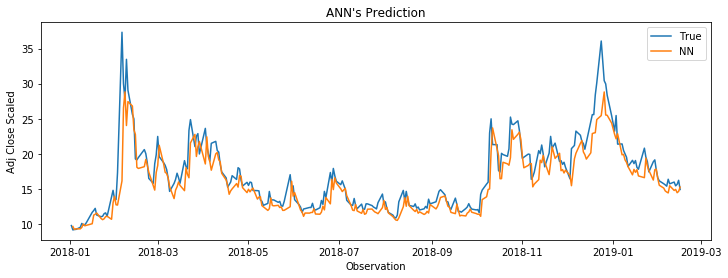

In [93]:
plt.figure(figsize=(12, 4))
plt.plot(test.index[:], scaler_y.inverse_transform(test_sc)[:,3], label='True')
plt.plot(test.index[1:], scaler_y.inverse_transform(y_pred_test_nn), label='NN')

## Just the last 100 days
# plt.plot(test.index[-100:],scaler_y.inverse_transform(y_test)[-100:], label='True')
# plt.plot(test.index[-100:],scaler_y.inverse_transform(y_pred_test_nn[-100:]), label='NN')

plt.title("ANN's Prediction")
plt.xlabel('Observation')
plt.ylabel('Adj Close Scaled')
plt.legend()
plt.show();

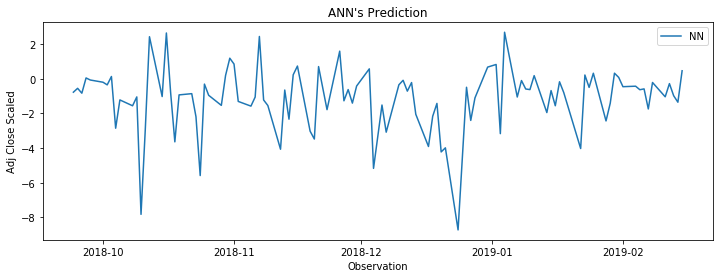

In [16]:
plt.figure(figsize=(12, 4))
plt.plot(test.index[-100:],scaler.inverse_transform(y_pred_test_nn)[-100:] - scaler.inverse_transform(y_test)[-100:], label='NN')
plt.title("ANN's Prediction")
plt.xlabel('Observation')
plt.ylabel('Adj Close Scaled')
plt.legend()
plt.show();

### It looks like using the previous days data is not sufficient. For the most part, the ANN just seems to be off by a day in its predictions

## LSTM
Now let's try a Long-Short-Term Memory Recurrent Neural Network.

Let's start with some better preparation of the data. We will use the `shift` pandas function to create columns with more previous days to be used for the prediction

In [100]:
train_sc_df = pd.DataFrame(train_sc, columns=['Open','Low','High','Y'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Open','Low','High','Y'], index=test.index)

## Get the close from the last 5 days
for s in range(1,6):
    print(s)
    train_sc_df['X_{}'.format(s)] = train_sc_df['Y'].shift(s)
    test_sc_df['X_{}'.format(s)] = test_sc_df['Y'].shift(s)

## Get rid of days for which we don't have the full history
X_train_LSTM = train_sc_df.dropna().drop('Y', axis=1)
y_train_LSTM = train_sc_df.dropna()[['Y']]

X_test_LSTM = test_sc_df.dropna().drop('Y', axis=1)
y_test_LSTM = test_sc_df.dropna()[['Y']]

# X_train_LSTM = X_train_LSTM.as_matrix()
# y_train_LSTM = y_train_LSTM.as_matrix()

# X_test_LSTM = X_test_LSTM.as_matrix()
# y_test_LSTM = y_test_LSTM.as_matrix()

1
2
3
4
5


In [95]:
nn_model = Sequential()
# nn_model.add(Dense(12, input_dim=1, activation='relu'))
nn_model.add(Dense(12, input_dim=8, activation='relu'))
# nn_model.add(Dense(12, input_dim=4, activation='relu'))
nn_model.add(Dense(1))
nn_model.compile(loss='mean_squared_error',optimizer='adam')
early_stop = EarlyStopping(monitor='loss',patience=2, verbose=1)
history = nn_model.fit(X_train_LSTM, y_train_LSTM, epochs=100, batch_size=1, verbose=1, callbacks=[early_stop], shuffle=False)

Epoch 1/100
1725/1725 [==============================] - 3s 2ms/step - loss: 0.0218
Epoch 2/100
1725/1725 [==============================] - 3s 1ms/step - loss: 0.0032
Epoch 3/100
1725/1725 [==============================] - 3s 2ms/step - loss: 0.0021
Epoch 4/100
1725/1725 [==============================] - 3s 2ms/step - loss: 0.0018
Epoch 5/100
1725/1725 [==============================] - 2s 1ms/step - loss: 0.0016
Epoch 6/100
1725/1725 [==============================] - 3s 1ms/step - loss: 0.0015
Epoch 7/100
1725/1725 [==============================] - 2s 1ms/step - loss: 0.0014
Epoch 8/100
1725/1725 [==============================] - 3s 2ms/step - loss: 0.0013
Epoch 9/100
1725/1725 [==============================] - 2s 1ms/step - loss: 0.0012
Epoch 10/100
1725/1725 [==============================] - 3s 2ms/step - loss: 0.0012
Epoch 11/100
1725/1725 [==============================] - 2s 1ms/step - loss: 0.0012
Epoch 12/100
1725/1725 [==============================] - 2s 1ms/step - lo

In [97]:
y_pred_test_nn = nn_model.predict(X_test_LSTM)
y_train_pred_nn = nn_model.predict(X_train_LSTM)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train_LSTM, y_train_pred_nn)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test_LSTM, y_pred_test_nn)))

The R2 score on the Train set is:	0.989
The R2 score on the Test set is:	0.935


ValueError: x and y must have same first dimension, but have shapes (1725,) and (283,)

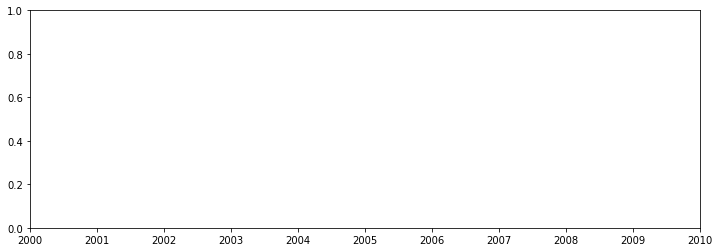

In [101]:
plt.figure(figsize=(12, 4))
plt.plot(X_train_LSTM.index[:], scaler_y.inverse_transform(test_sc)[:,3], label='True')
plt.plot(X_train_LSTM.index[1:], scaler_y.inverse_transform(y_pred_test_nn), label='NN')

## Just the last 100 days
# plt.plot(test.index[-100:],scaler_y.inverse_transform(y_test)[-100:], label='True')
# plt.plot(test.index[-100:],scaler_y.inverse_transform(y_pred_test_nn[-100:]), label='NN')

plt.title("ANN's Prediction")
plt.xlabel('Observation')
plt.ylabel('Adj Close Scaled')
plt.legend()
plt.show();